In [432]:
import json
import math
import requests

import numpy as np
from scipy.optimize import curve_fit

In [142]:
from collections import defaultdict
import json

import matplotlib.pyplot as plt

In [2]:
api_key = "ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQDItfZ7ys1EcPmRJ3wYcVgLlLmcEHdi7Bwe54z2mxPPPUx5hSipEbhrGz1AsEAnjAcsG2+OILZ04zqsZRPL/+vabYFBJG755+ouwSd/nPok3h9B0WGgcgXPQ69Bo+jlKtQqAwLPyHcql4qUK2mvfJzHKD2+m/XmngWNnhfkhnbFSq2k2VYSPQg58nQn735V+Qhr29sFcdr/WiC6748vxpgiIQetSG796HdxdpiW6nOefeBJ1OvhaTz3tBuBzBLQ210vTVKyaeRup6eVbZAu/Wrg4b+DIfnYKnsIw+8LhofCEpKNUA0OVAcMjmrS4o6CQrWUk88sW/SI/mXmUNrEGruF zero@Rishabhs-MacBook-Air.local"

In [271]:
response = requests.get(
    "http://tahoma.stanford.edu:8000/total_flops_used", {"api_key": api_key}
)
print(f"{response.json():.1e}")

1.2e+18


In [31]:
def pp(x):
    print(f"{x:.1e}")

In [3]:
config = {
    "d_model": 64,
    "num_layers": 2,
    "num_heads": 16,
    "batch_size": 128,
    "learning_rate": 1e-3,
    "train_flops": int(1e13),
    "api_key": api_key,
}

In [5]:
# response = requests.get("http://tahoma.stanford.edu:8000/loss", config).json()
response

{'loss': 10.529671605287241, 'total_flops_used': 10000000000000}

In [72]:
def query(train_flops, d_model, num_layers, num_heads):
    config = {
        "d_model": d_model,
        "num_layers": num_layers,
        "num_heads": num_heads,
        "batch_size": 128,
        "learning_rate": 1e-4,
        "train_flops": train_flops,
        "api_key": api_key,
    }
    response = requests.get("http://tahoma.stanford.edu:8000/loss", config).json()
    print(json.dumps(config))
    print(json.dumps(response))
    with open("requests.jsonl", "a") as f:
        f.write(json.dumps(config))
        f.write("\n")
    with open("log.jsonl", "a") as f:
        f.write(json.dumps({
            "request": config,
            "response": response,
        }))
        f.write("\n")

In [26]:
def calc_N_init(C):
    return 0.1 * C**0.5

In [51]:
def calc_num_layers(N, k_1=32):
    return (N / (12 * k_1**2)) ** (1 / 3)

In [52]:
def calc_shape(num_layers, N, k_1=32, k_2=32):
    d_model = k_1 * num_layers
    num_heads = (k_1 * num_layers) // k_2
    N_ret = 12 * num_layers * d_model**2
    print(f"{N=:.1e} {N_ret=:.1e}")
    return {
        "num_layers": num_layers,
        "d_model": d_model,
        "num_heads": num_heads,
    }

In [76]:
def suggest(C):
    N_init = calc_N_init(C)
    print(f"{N_init=:.1e}")
    l = calc_num_layers(N_init)
    print(f"{l=:.2f}")
    return N_init, l

In [486]:
N_opt = yy
pp(N_opt)

2.3e+00


In [485]:
l = calc_num_layers(N_opt)
l

0.057308748111758616

In [473]:
calc_shape(27, N_opt)

N=2.4e+08 N_ret=2.4e+08


{'num_layers': 27, 'd_model': 864, 'num_heads': 27}

In [422]:
C = 3e16

In [423]:
N_init, l = suggest(C)

N_init=1.7e+07
l=11.21


In [424]:
num_layers = 6

In [425]:
shape = calc_shape(num_layers, N_init)
shape

N=1.7e+07 N_ret=2.7e+06


{'num_layers': 6, 'd_model': 192, 'num_heads': 6}

In [426]:
pp(C)

3.0e+16


In [427]:
query(
    train_flops=int(C),
    d_model=shape["d_model"],
    num_layers=shape["num_layers"],
    num_heads=shape["num_heads"],
)

{"d_model": 192, "num_layers": 6, "num_heads": 6, "batch_size": 128, "learning_rate": 0.0001, "train_flops": 30000000000000000, "api_key": "ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQDItfZ7ys1EcPmRJ3wYcVgLlLmcEHdi7Bwe54z2mxPPPUx5hSipEbhrGz1AsEAnjAcsG2+OILZ04zqsZRPL/+vabYFBJG755+ouwSd/nPok3h9B0WGgcgXPQ69Bo+jlKtQqAwLPyHcql4qUK2mvfJzHKD2+m/XmngWNnhfkhnbFSq2k2VYSPQg58nQn735V+Qhr29sFcdr/WiC6748vxpgiIQetSG796HdxdpiW6nOefeBJ1OvhaTz3tBuBzBLQ210vTVKyaeRup6eVbZAu/Wrg4b+DIfnYKnsIw+8LhofCEpKNUA0OVAcMjmrS4o6CQrWUk88sW/SI/mXmUNrEGruF zero@Rishabhs-MacBook-Air.local"}
{"loss": 6.181043592518977, "total_flops_used": 1999970000000000000}


In [428]:
isoflops = defaultdict(dict)
with open("log.jsonl", "r") as f:
    while True:
        try:
            obj = json.loads(f.readline())
            C = float(obj["request"]["train_flops"])
            l = obj["request"]["num_layers"]
            d = obj["request"]["d_model"]
            N = 12 * l * d ** 2
            print(obj["response"])
            loss = obj["response"]["loss"]
            isoflops[C][N] = loss
        except json.JSONDecodeError:
            break
        except KeyError:
            print(obj["response"])
            continue
# isoflops

{'loss': 10.541156144275838, 'total_flops_used': 20000000000000}
{'loss': 10.520162580466815, 'total_flops_used': 50000000000000}
{'loss': 10.533115660105933, 'total_flops_used': 80000000000000}
{'loss': 10.531017223205865, 'total_flops_used': 110000000000000}
{'loss': 10.477322251170936, 'total_flops_used': 170000000000000}
{'loss': 10.507595612221243, 'total_flops_used': 230000000000000}
{'loss': 10.498196517254259, 'total_flops_used': 290000000000000}
{'loss': 9.811663075232396, 'total_flops_used': 590000000000000}
{'loss': 9.80988718668489, 'total_flops_used': 890000000000000}
{'loss': 10.020089926305353, 'total_flops_used': 1190000000000000}
{'loss': 8.95941397067573, 'total_flops_used': 1790000000000000}
{'loss': 9.287044764134256, 'total_flops_used': 2390000000000000}
{'loss': 8.851739477162086, 'total_flops_used': 2990000000000000}
{'loss': 7.529982948083629, 'total_flops_used': 5990000000000000}
{'loss': 7.568901380428977, 'total_flops_used': 8990000000000000}
{'loss': 7.45537

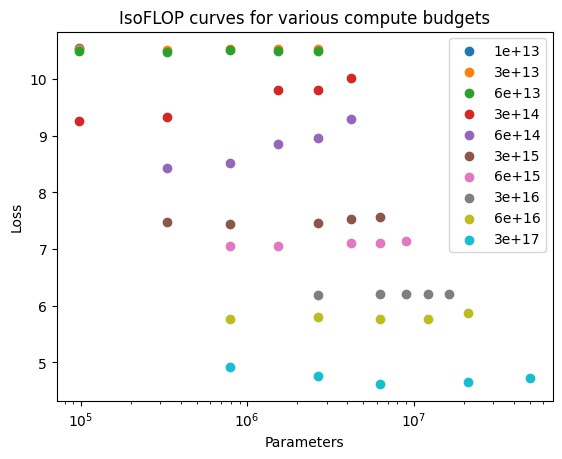

In [429]:
fig, ax = plt.subplots()
for C, loss_for_N in isoflops.items():
    x = list(loss_for_N.keys())
    y = list(loss_for_N.values())
    ax.scatter(x, y, label=f"{C:.0e}")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Parameters")
ax.set_ylabel("Loss")
ax.set_title("IsoFLOP curves for various compute budgets")
fig.show()

/tmp/user/23092/ipykernel_616224/2501099989.py:22: RuntimeWarning: invalid value encountered in log
  ys = a*np.log(xs)**2 + b*np.log(xs) + c


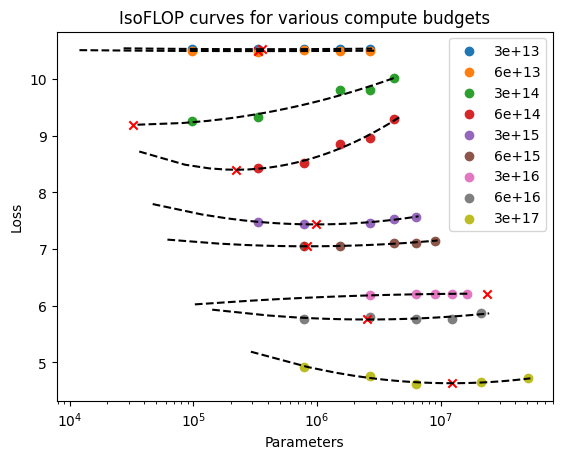

In [476]:
fig, ax = plt.subplots()
n_opt = {}
loss_opt = {}
for C, loss_for_N in isoflops.items():
    if C == 1e13:
        continue
    x = list(loss_for_N.keys())
    y = list(loss_for_N.values())
    ax.scatter(x, y, label=f"{C:.0e}")
    
    lx = [math.log(x_) for x_ in x]
    out = curve_fit(lambda z, a, b, c: a*z**2 + b*z + c, lx, y)
    a, b, c = out[0]
    lx_opt = -b/(2*a)
    x_opt = math.exp(lx_opt)
    y_opt = a*lx_opt**2 + b*lx_opt + c
    n_opt[C] = x_opt
    loss_opt[C] = y_opt
    
    xmin, xmax = ax.get_xlim()
    xs = np.linspace(xmin, xmax, 100)
    ys = a*np.log(xs)**2 + b*np.log(xs) + c
    ax.plot(xs, ys, ls="--", color="black")
    ax.scatter(x_opt, y_opt, color="red", marker="x")
    
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Parameters")
ax.set_ylabel("Loss")
ax.set_title("IsoFLOP curves for various compute budgets")
fig.show()

6.3e+07


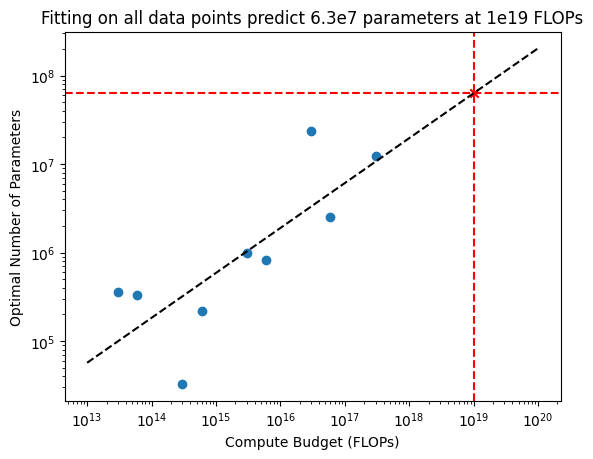

In [464]:
fig, ax = plt.subplots()
x = list(n_opt.keys())
y = list(n_opt.values())
ax.scatter(x, y)
lx = [math.log(x_) for x_ in x]
ly = [math.log(y_) for y_ in y]
out = curve_fit(lambda x, a, b: a*x + b, lx, ly)
a, b = out[0]
xmin = 1e13
xmax = 1e20
xs = np.linspace(xmin, xmax)
ys = np.exp(a*np.log(xs) + b)
ax.plot(xs, ys, ls="--", color="black")
xx = 1e19
yy = np.exp(a*np.log(xx) + b)
pp(yy)
ax.axvline(xx, color="red", ls="--")
ax.axhline(yy, color="red", ls="--")
ax.scatter(xx, yy, color="red", marker="x")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Compute Budget (FLOPs)")
ax.set_ylabel("Optimal Number of Parameters")
ax.set_title("Fitting on all data points predict 6.3e7 parameters at 1e19 FLOPs")
fig.show()

243645818.39757246


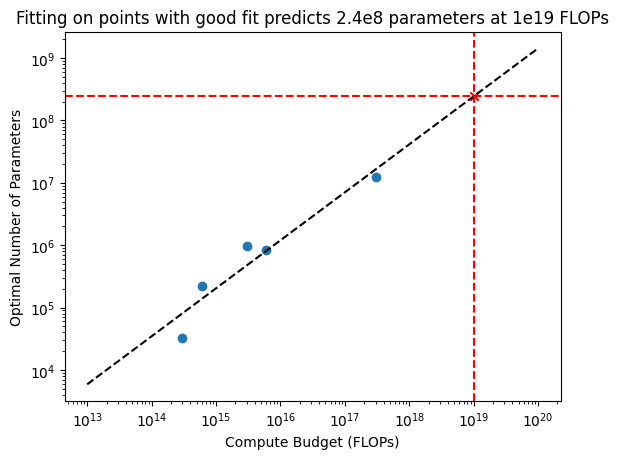

In [495]:
fig, ax = plt.subplots()
x = [3e14, 6e14, 3e15, 6e15, 3e17]
y = [n_opt[x_] for x_ in x]
ax.scatter(x, y)
lx = [math.log(x_) for x_ in x]
ly = [math.log(y_) for y_ in y]
out = curve_fit(lambda x, a, b: a*x + b, lx, ly)
a, b = out[0]
xmin = 1e13
xmax = 1e20
xs = np.linspace(xmin, xmax)
ys = np.exp(a*np.log(xs) + b)
ax.plot(xs, ys, ls="--", color="black")
xx = 1e19
yy = np.exp(a*np.log(xx) + b)
print(yy)
ax.axvline(xx, color="red", ls="--")
ax.axhline(yy, color="red", ls="--")
ax.scatter(xx, yy, color="red", marker="x")
ax.set_xlabel("Compute Budget (FLOPs)")
ax.set_ylabel("Optimal Number of Parameters")
ax.set_title("Fitting on points with good fit predicts 2.4e8 parameters at 1e19 FLOPs")
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()

3.6109239600900414


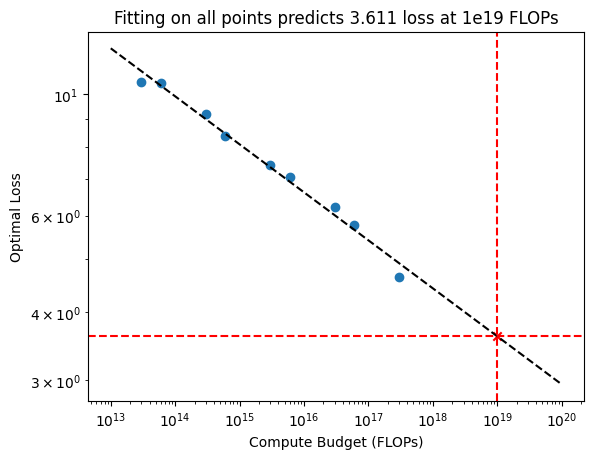

In [492]:
fig, ax = plt.subplots()
x = list(loss_opt.keys())
y = [loss_opt[x_] for x_ in x]
ax.scatter(x, y)
lx = [math.log(x_) for x_ in x]
ly = [math.log(y_) for y_ in y]
out = curve_fit(lambda x, a, b: a*x + b, lx, ly)
a, b = out[0]
xmin = 1e13
xmax = 1e20
xs = np.geomspace(xmin, xmax)
ys = np.exp(a*np.log(xs) + b)
ax.plot(xs, ys, ls="--", color="black")
xx = 1e19
yy = np.exp(a*np.log(xx) + b)
print(yy)
ax.axvline(xx, color="red", ls="--")
ax.axhline(yy, color="red", ls="--")
ax.scatter(xx, yy, color="red", marker="x")
ax.set_xlabel("Compute Budget (FLOPs)")
ax.set_ylabel("Optimal Loss")
ax.set_title("Fitting on all points predicts 3.611 loss at 1e19 FLOPs")
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()

3.3321723298478574


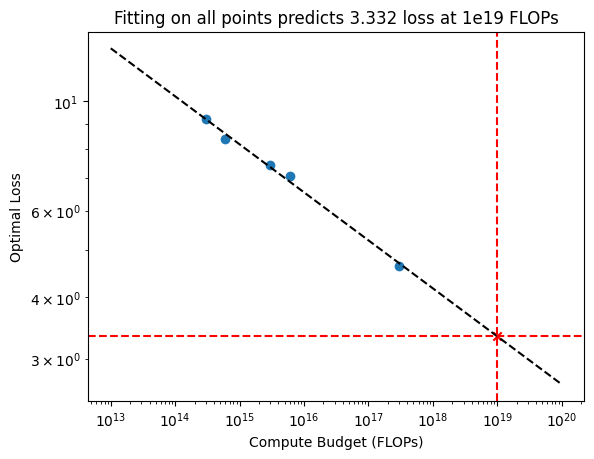

In [494]:
fig, ax = plt.subplots()
x = [3e14, 6e14, 3e15, 6e15, 3e17]
y = [loss_opt[x_] for x_ in x]
ax.scatter(x, y)
lx = [math.log(x_) for x_ in x]
ly = [math.log(y_) for y_ in y]
out = curve_fit(lambda x, a, b: a*x + b, lx, ly)
a, b = out[0]
xmin = 1e13
xmax = 1e20
xs = np.geomspace(xmin, xmax)
ys = np.exp(a*np.log(xs) + b)
ax.plot(xs, ys, ls="--", color="black")
xx = 1e19
yy = np.exp(a*np.log(xx) + b)
print(yy)
ax.axvline(xx, color="red", ls="--")
ax.axhline(yy, color="red", ls="--")
ax.scatter(xx, yy, color="red", marker="x")
ax.set_xlabel("Compute Budget (FLOPs)")
ax.set_ylabel("Optimal Loss")
ax.set_title("Fitting on all points predicts 3.332 loss at 1e19 FLOPs")
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()

/tmp/user/23092/ipykernel_616224/4194154447.py:18: RuntimeWarning: invalid value encountered in log
  ys = a*np.log(xs)**2 + b*np.log(xs) + c


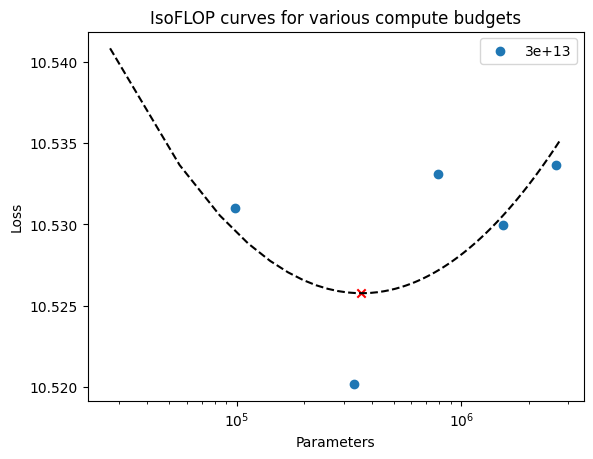

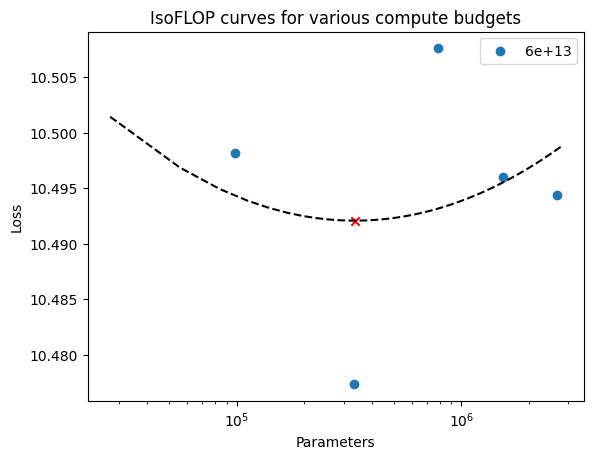

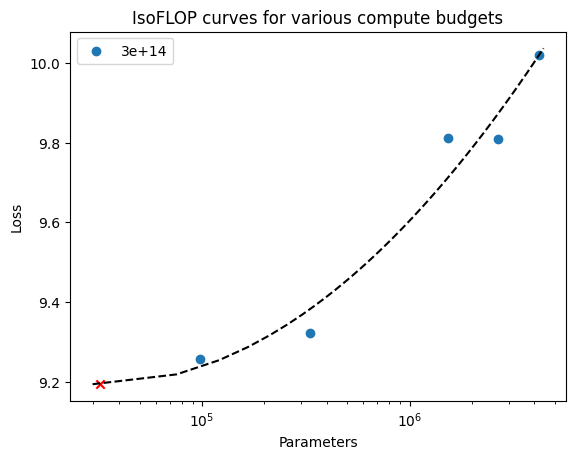

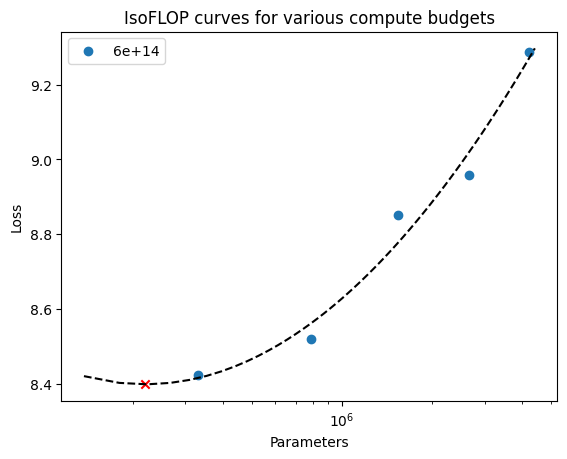

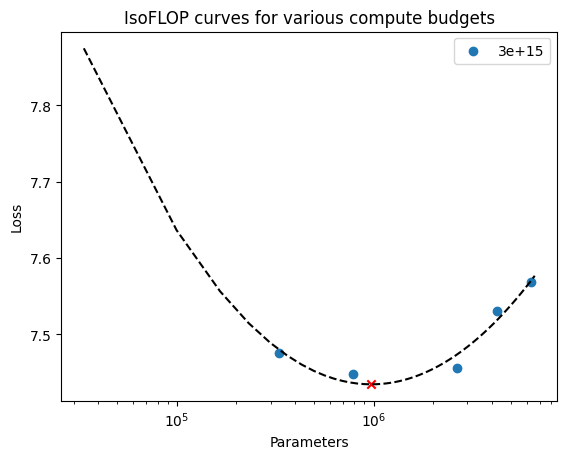

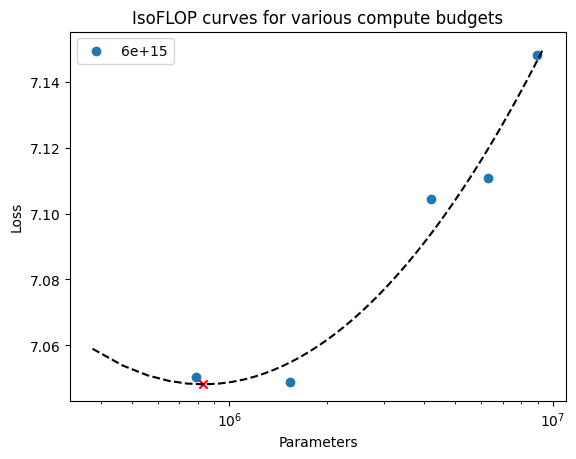

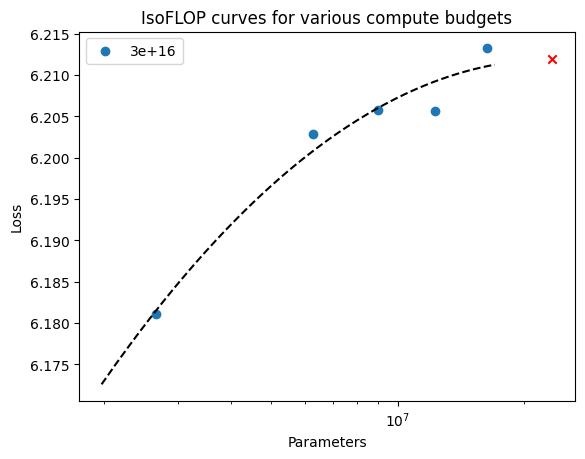

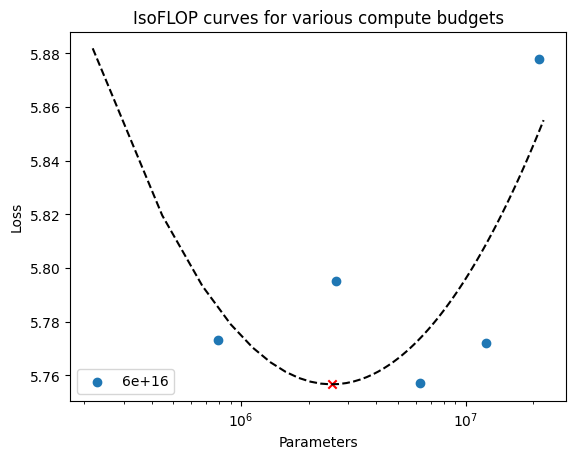

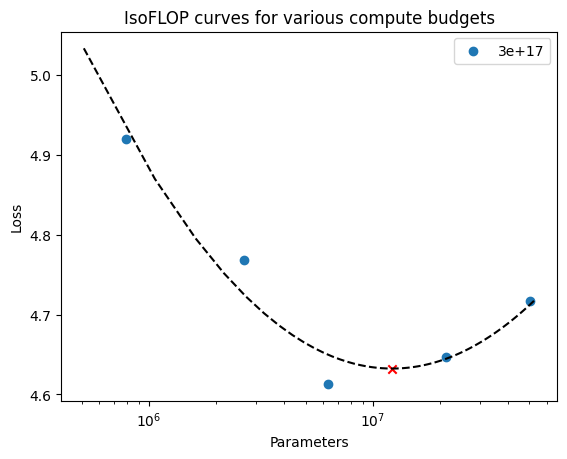

In [439]:
for C, loss_for_N in isoflops.items():
    if C == 1e13:
        continue
    fig, ax = plt.subplots()
    x = list(loss_for_N.keys())
    y = list(loss_for_N.values())
    ax.scatter(x, y, label=f"{C:.0e}")
    
    lx = [math.log(x_) for x_ in x]
    out = curve_fit(lambda z, a, b, c: a*z**2 + b*z + c, lx, y)
    a, b, c = out[0]
    lx_opt = -b/(2*a)
    x_opt = math.exp(lx_opt)
    y_opt = a*lx_opt**2 + b*lx_opt + c
    
    xmin, xmax = ax.get_xlim()
    xs = np.linspace(xmin, xmax, 100)
    ys = a*np.log(xs)**2 + b*np.log(xs) + c
    ax.plot(xs, ys, ls="--", color="black")
    ax.scatter(x_opt, y_opt, color="red", marker="x")
    
    ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel("Parameters")
    ax.set_ylabel("Loss")
    ax.set_title("IsoFLOP curves for various compute budgets")
    fig.show()